# MGMGT 638-001 Assignment 1 
## Part 2: Pairs Strategy
Identify two stocks to use in a pairs strategy.  Backtest the strategy and compute its alpha.

Author: Francho Garcia Takis <br>
Date: 06-11-2024

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import statsmodels.formula.api as smf
from pandas_datareader import DataReader as pdr

np.random.seed(6112024)

### Identifying a Stock Pair

In [2]:
sector = 'Financials'

sector_tickers = pd.read_csv(f'../data/sector tickers/{sector}.csv')
sector_tickers = sector_tickers['Symbol'].dropna().tolist()

In [3]:
stock_data = pd.DataFrame()

for ticker in sector_tickers:
    try:
        data = yf.download(ticker, progress=False)
        if not data.empty:
            stock_data[ticker] = data['Adj Close'].pct_change() 
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")

corr_matrix = stock_data.corr()
corr_matrix = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

sorted_corrs = corr_matrix.unstack().sort_values(ascending=False).dropna()
sorted_corrs = sorted_corrs.reset_index()
sorted_corrs.columns = ['ticker1', 'ticker2', 'correlation']
sorted_corrs.head()


1 Failed download:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


,ticker1,ticker2,correlation
0,FITB,CFG,0.894116
1,KEY,CFG,0.892703
2,RF,CFG,0.889700
3,HBAN,CFG,0.865309
4,PNC,CFG,0.864888


[*********************100%***********************]  2 of 2 completed


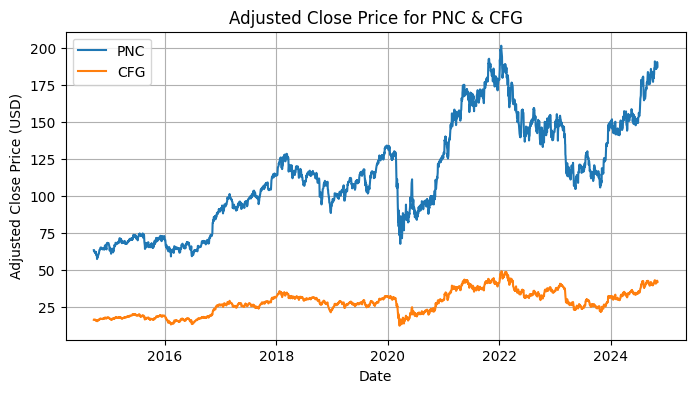

In [4]:
#Select chosen stocks: 
ticker1, ticker2 = 'PNC', 'CFG'

#Get the data:
data = yf.download([ticker1, ticker2])['Adj Close'].dropna() #dropna to keep the data for when both stocks exist
data.index = pd.to_datetime(data.index.strftime("%Y-%m-%d"))

#Plot: 
plt.figure(figsize=(8,4))
plt.plot(data[ticker1], label=ticker1)
plt.plot(data[ticker2], label=ticker2)
plt.title(f"Adjusted Close Price for {ticker1} & {ticker2}")
plt.ylabel('Adjusted Close Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.grid()

plt.show()

### Fitting the Pairs Strategy

In [5]:
#Calculating the ratio between the pair:
data['ratio'] = data[ticker1] / data[ticker2]
data['lagged_ratio'] = data['ratio'].shift()
data['delta_ratio'] = data['ratio'].diff()
data = data.dropna()

In [6]:
# Train and testing splits (80/20):
cutoff_date = data.index[int(0.8*len(data))] 
print(f"Train-test split date: {cutoff_date.date()}")

train = data[:cutoff_date].copy()
print(f"Training set is from {train.index[0].date()} to {train.index[-1].date()}")

test = data[data.index > cutoff_date].copy()
print(f"Testing set is from {test.index[0].date()} to {test.index[-1].date()}")

Train-test split date: 2022-10-25
Training set is from 2014-09-25 to 2022-10-25
Testing set is from 2022-10-26 to 2024-11-01


In [7]:
#Regression formula 
reg = smf.ols(formula='delta_ratio ~ lagged_ratio', data=train)
alpha, beta = reg.fit().params

print("\
Regression Results:")
print(f"Intercept (alpha) {alpha:.2f}")
print(f"Slope (beta): {beta:.2f}")
print(f"Ratio or Constant (-alpha/beta): {-alpha/beta:.2f}")

Regression Results:
Intercept (alpha) 0.05
Slope (beta): -0.01
Ratio or Constant (-alpha/beta): 4.02


### Testing & Evaluating the Pairs Strategy

In [8]:
#Determining a threshold for the buy/short decision on the pair:
threshold = train['ratio'].std() * 2 # Execute if ratio deviated up/down by 2 std devs

#Applying the model to the test data:
test[f'BuyShort_{ticker1}'] = (
    1 * (test.lagged_ratio < -alpha/beta - threshold) # Buy ticker1 if ratio dips below threshold
    - 1 * (test.lagged_ratio > -alpha/beta + threshold) # Short if ratio rises above threshold
)
test[f'BuyShort_{ticker2}'] = -test[f'BuyShort_{ticker1}'] # Inverse for ticker2

#Calculating the returns:
test['returns'] = (
    test[f'BuyShort_{ticker1}'] * test[ticker1].pct_change() 
    + test[f'BuyShort_{ticker2}'] * test[ticker2].pct_change()
)

#Retrieving the market excess returns:
ff = pdr('F-F_Research_Data_Factors_daily', 'famafrench', start=2000)[0]
test['mkt_excess'] = ff['Mkt-RF'] #market excess returns

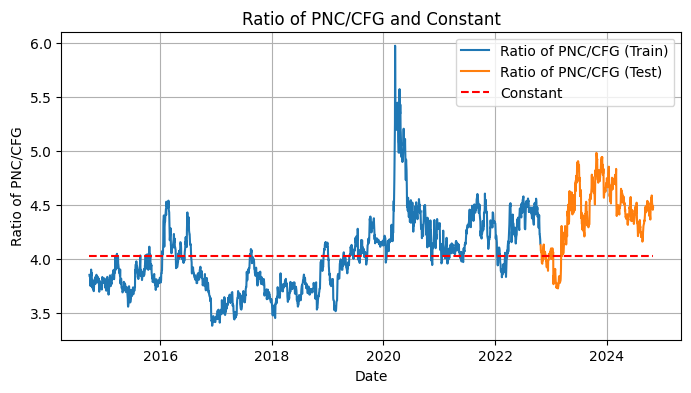

In [9]:
plt.figure(figsize=(8,4))
plt.plot(train['ratio'], label=f"Ratio of {ticker1}/{ticker2} (Train)")
plt.plot(test['ratio'], label=f"Ratio of {ticker1}/{ticker2} (Test)")
#Add the constant (-alpha/beta) to the plot:
plt.hlines(-alpha/beta, 
            xmin=train.index[0], xmax=test.index[-1],
            color='red', linestyle='--', label='Constant')
plt.title(f"Ratio of {ticker1}/{ticker2} and Constant")
plt.ylabel(f"Ratio of {ticker1}/{ticker2}")
plt.xlabel("Date")
plt.legend()
plt.grid()

plt.show()

In [10]:
print(f"Mean return of pairs strategy = {252*test.returns.mean():.2%} annualized")
print(f"Correlation of pairs strategy with market = {test.returns.corr(test.mkt_excess):.2f}")

Mean return of pairs strategy = 12.65% annualized
Correlation of pairs strategy with market = 0.10


In [11]:
test_beta = test.returns.corr(test.mkt_excess) * test.returns.std() / test.mkt_excess.std()
test_alpa = test.returns.mean() - test_beta * test.mkt_excess.mean()

print(f"Beta of pairs strategy = {test_beta:.4f}")
print(f"Annualised alpha is {252*test_alpa:.2%}")

Beta of pairs strategy = 0.0005
Annualised alpha is 11.71%


In [12]:
smf.ols(formula='returns ~ mkt_excess', data=test).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                returns   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     4.679
Date:                Sat, 02 Nov 2024   Prob (F-statistic):             0.0310
Time:                        17:25:58   Log-Likelihood:                 1864.9
No. Observations:                 483   AIC:                            -3726.
Df Residuals:                     481   BIC:                            -3717.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.000      2.094      0.037    3.01e-05       0.001
mkt_excess     0.0005      0.000      2.163      0.031    4.95e-05       0.001
==============================================================================
Omnibus:                      361.508   Durbin-Watson:                   2.242
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10060.453
Skew:                           2.899   Prob(JB):                         0.00
Kurtosis:                      24.593   Cond. No.                         1.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Observations
- This strategy seems market neutral given the near-zero correlation with the market excess returns. In the case of FITB/CFG the $\beta$ is also near zero and statistically insignificant at the 5% level, whilst in the case of PNC/CFG it is statistically significantly greater than 0, but very small in size. 

- For FITB/CFG the annualised alpha shows that the returns of the strategy seemingly are 3.45% above what would be expected for the level of market risk of the strategy. However, the regression results show these $\alpha$ returns are not statistically significant. For PNC/CFG, annualised alpha seems to be 11.7% according to the 2 years of data, but a regression places it closer to 0.05% although indeed statistically significant. 

- The importance of the threshold and the correlation between the pair: In the case of HBAN/CFG, the ratio of the price of the stocks is remarkably constant and thus produces a case where the threshold is never superceeded to execute a buy/short trade. 